# Start of DS5559 Final Project

Team Left Twix Members

* Alice Wright - aew7j
* Edward Thompson - ejt8b
* Michael Davies -  mld9s
* Sam Parsons - sp8hp

In STAT 6021 members of our cohort looked at Transportation Network Company data sets to see if there was a potential relationship between tipping and other indicators, specifically with “transportation network providers” i.e. rideshares such as Uber, Lyft, etc.  At that point in our Data Science journey we did not have the skills or equipment to investigate this question in depth.  

Utilizing machine learning skills from SYS 6018 and applying Spark to this dataset we hope to come up with a more robust set of answers and potentially a better predictor of tipping. With other classification algorithms such as random forest and the heavy-weight data processing of Spark, will we be able to create a more robust predictive model?


Potential Questions from the TNC Data:

* Can it be predicted what fares are most likely to tip the driver?
* Is there a relationship between time of the fare and tipping? (workday stat, bar close, weekday, weekend, etc)
* Is there a relationship between start or end location of the ride and tipping? (downtown pickup, north shore, airport, etc)
* Is there a relationship between length or cost of ride and tipping? (do longer rides result in tips)
* Using this data would we be able to make recommendations to drivers to maximize likelihood of receiving a tip?
* Is the likelihood of tipping changing over time?  Are more rides being tipped?
* Are there re-identification abilities in this dataset? For instance, can we find records for a person who reliably takes a rideshare to/from work every day thereby linking a home address to a work address?




Additionally, joining in additional datasets may yield answers to questions about external factors such as:
* How did news reporting/social media on rideshare companies correlate with tipping?
* What relationship(s) does trip demand have with the stocks of these companies?

Data Source:
The best data source for this appears to be from the City of Chicago, as it is large (169M records and 21 columns), relatively clean, anonymized, and accessible via API.

City of Chicago:
https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p

So far we have only pulled the data down via a CSV.

Code Rubric

* Data Import and PreProcessing | 2 pts

* Data splitting/sampling | 1 pt

* EDA (min two graphs) | 2 pts

* Model construction (min 3 models) | 3 pts

* Model evaluation | 2 pts

In [73]:
# import context manager: SparkSession
from pyspark.sql import SparkSession

# import data types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType
import pyspark.sql.types as typ
import pyspark.sql.functions as F
import os

from pyspark.sql.types import *

spark = SparkSession.builder \
        .master("local[*]") \
        .appName("mllib_classifier") \
        .config("spark.executor.memory", '21g') \
        .config('spark.executor.cores', '2') \
        .config('spark.executor.instances', '3') \
        .config("spark.driver.memory",'1g') \
        .getOrCreate()
sc = spark.sparkContext

In [2]:
%whos

Variable        Type            Data/Info
-----------------------------------------
ArrayType       type            <class 'pyspark.sql.types.ArrayType'>
BinaryType      type            <class 'pyspark.sql.types.BinaryType'>
BooleanType     type            <class 'pyspark.sql.types.BooleanType'>
ByteType        type            <class 'pyspark.sql.types.ByteType'>
DataType        type            <class 'pyspark.sql.types.DataType'>
DateType        type            <class 'pyspark.sql.types.DateType'>
DecimalType     type            <class 'pyspark.sql.types.DecimalType'>
DoubleType      type            <class 'pyspark.sql.types.DoubleType'>
F               module          <module 'pyspark.sql.func<...>yspark/sql/functions.py'>
FloatType       type            <class 'pyspark.sql.types.FloatType'>
IntegerType     type            <class 'pyspark.sql.types.IntegerType'>
LongType        type            <class 'pyspark.sql.types.LongType'>
MapType         type            <class 'pyspark.sql.ty

In [3]:
#clear old df
#del (df)

# Read in our Dataset

## Create a Custom Schema.  
This schema was been primarly determined by using a much smaller dataset and letting spark infer the schema.  We encountered an issue with spark reading in the ENTIRE dataset as NULL when there was a type mismatch.  Only the data we are likely to use later has been assigned to a specific type, otherwise it is left as a string type.

In [74]:
# create a custom schema.  

customSchema = StructType([
    StructField('Trip_ID', StringType(), True),        
    StructField('Trip_Start_Timestamp', StringType(), True),
    StructField('Trip_End_Timestamp', StringType(), True),
    StructField('Trip_Seconds', DoubleType(), True),
    StructField('Trip_Miles', DoubleType(), True),
    StructField('Pickup_Census_Tract', StringType(), True),
    StructField('Dropoff_Census_Tract', StringType(), True),
    StructField('Pickup_Community_Area', DoubleType(), True),
    StructField('Dropoff_Community_Area', DoubleType(), True),
    StructField("Fare", DoubleType(), True),
    StructField("Tip", DoubleType(), True),
    StructField("Additional_Charges", DoubleType(), True),
    StructField("Trip_Total", StringType(), True),
    StructField("Shared_Trip_Authorized", BooleanType(), True),
    StructField("Trips_Pooled", DoubleType(), True),
    StructField('Pickup_Centroid_Latitude', StringType(), True),
    StructField('Pickup_Centroid_Longitude', StringType(), True),
    StructField('Pickup_Centroid_Location', StringType(), True),
    StructField('Dropoff_Centroid_Latitude', StringType(), True),
    StructField('Dropoff_Centroid_Longitude', StringType(), True),
    StructField('Dropoff_Centroid_Location', StringType(), True)
])

#old readin.  Infer is slow for large dataset
#df = spark.read.csv('/../../project/ds5559/Alice_Ed_Michael_Sam_project/BigTrips.csv', header = True, inferSchema=True)

#read in the data to a dataframe
df = spark.read.csv('/../../project/ds5559/Alice_Ed_Michael_Sam_project/BigTrips.csv', header = True, schema=customSchema)
df.show(5)

+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|             Trip_ID|Trip_Start_Timestamp|  Trip_End_Timestamp|Trip_Seconds|Trip_Miles|Pickup_Census_Tract|Dropoff_Census_Tract|Pickup_Community_Area|Dropoff_Community_Area|Fare|Tip|Additional_Charges|Trip_Total|Shared_Trip_Authorized|Trips_Pooled|Pickup_Centroid_Latitude|Pickup_Centroid_Longitude|Pickup_Centroid_Location|Dropoff_Centroid_Latitude|Dropoff_Centroid_Longitude|Dropoff_Centroid_Location|
+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+-------

In [75]:
rdd = sc.textFile('/../../project/ds5559/Alice_Ed_Michael_Sam_project/BigTrips.csv')
rdd = rdd.map(lambda x: x.split(","))

In [76]:
rdd.take(1)

[['Trip ID',
  'Trip Start Timestamp',
  'Trip End Timestamp',
  'Trip Seconds',
  'Trip Miles',
  'Pickup Census Tract',
  'Dropoff Census Tract',
  'Pickup Community Area',
  'Dropoff Community Area',
  'Fare',
  'Tip',
  'Additional Charges',
  'Trip Total',
  'Shared Trip Authorized',
  'Trips Pooled',
  'Pickup Centroid Latitude',
  'Pickup Centroid Longitude',
  'Pickup Centroid Location',
  'Dropoff Centroid Latitude',
  'Dropoff Centroid Longitude',
  'Dropoff Centroid Location']]

In [7]:
#https://stackoverflow.com/questions/53304688/spark-date-format-mmm-dd-yyyy-hhmmss-am-to-timestamp-in-df
#https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html
start_times = rdd.map(lambda x: (x[0],x[1]))

In [8]:
start_times = start_times.toDF()

In [9]:
st = start_times.withColumn("_2",to_timestamp(col("_2"), "MM/dd/yyyy hh:mm:ss a"))

NameError: name 'to_timestamp' is not defined

In [ ]:
st = start_times.withColumn("_2",to_timestamp(col("_2"), "MM/dd/yyyy hh:mm:ss a"))

In [77]:
#Doesn't update if you don't resave the variable

df = df.drop('Trip_End_Timestamp', 
             'Pickup_Census_Tract',
             'Dropoff_Census_Tract',
             'Pickup_Centroid_Latitude',
             'Pickup_Centroid_Longitude', 
             'Pickup_Centroid_Location', 
             'Dropoff_Centroid_Latitude', 
             'Dropoff_Centroid_Longitude', 
             'Dropoff_Centroid_Location')

In [78]:
df.printSchema()

root
 |-- Trip_ID: string (nullable = true)
 |-- Trip_Start_Timestamp: string (nullable = true)
 |-- Trip_Seconds: double (nullable = true)
 |-- Trip_Miles: double (nullable = true)
 |-- Pickup_Community_Area: double (nullable = true)
 |-- Dropoff_Community_Area: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: double (nullable = true)
 |-- Additional_Charges: double (nullable = true)
 |-- Trip_Total: string (nullable = true)
 |-- Shared_Trip_Authorized: boolean (nullable = true)
 |-- Trips_Pooled: double (nullable = true)



In [11]:
df.count()

49108003

Make a sampled dataframe for faster work while developing all the steps.

In [79]:
df2 = df.sample(False, .0005, 1221)

In [80]:
df2.count()

24414

In [81]:
#delete the big df for now
del (df)

#hopefully that will make things faster 

In [15]:
# df.select('Trip_ID').count()

NameError: name 'df' is not defined

In [ ]:
# df.describe()

From reading the data dictionary it appears that there are multiple ways that pickup and drop off locations are being reported.

Can we do histograms of the pickup and drop off areas?  To see if there are desinations that are popular (Airports, downtown, ball parks, museum row... etc)

## Fare and Tip Heatmap

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

In [17]:
#https://spark.apache.org/docs/2.2.0/api/python/pyspark.sql.html#module-pyspark.sql.functions
heatmap_data = df2.groupby('Fare','Tip').count().sort('Fare','Tip').groupby('Fare').pivot('Tip').sum("count").sort('Fare')
heatmap_data.cache()

DataFrame[Fare: double, 0.0: bigint, 1.0: bigint, 2.0: bigint, 3.0: bigint, 4.0: bigint, 5.0: bigint, 6.0: bigint, 7.0: bigint, 8.0: bigint, 9.0: bigint, 10.0: bigint, 11.0: bigint, 12.0: bigint, 13.0: bigint, 14.0: bigint, 15.0: bigint, 16.0: bigint, 18.0: bigint, 20.0: bigint, 21.0: bigint, 22.0: bigint, 25.0: bigint, 35.0: bigint, 36.0: bigint, 50.0: bigint]

In [18]:
hm_data = np.array(heatmap_data.drop('Fare').toPandas())

In [19]:
#https://numpy.org/doc/stable/reference/generated/numpy.flipud.html#numpy.flipud
hm_data = np.flipud(hm_data.transpose())

In [20]:
#https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/
fares = list(heatmap_data.select('Fare').toPandas()['Fare'])
tips = sorted([float(x) for x in heatmap_data.columns if x != 'Fare'], reverse=True)

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Tip Amounts by Fare Amounts')

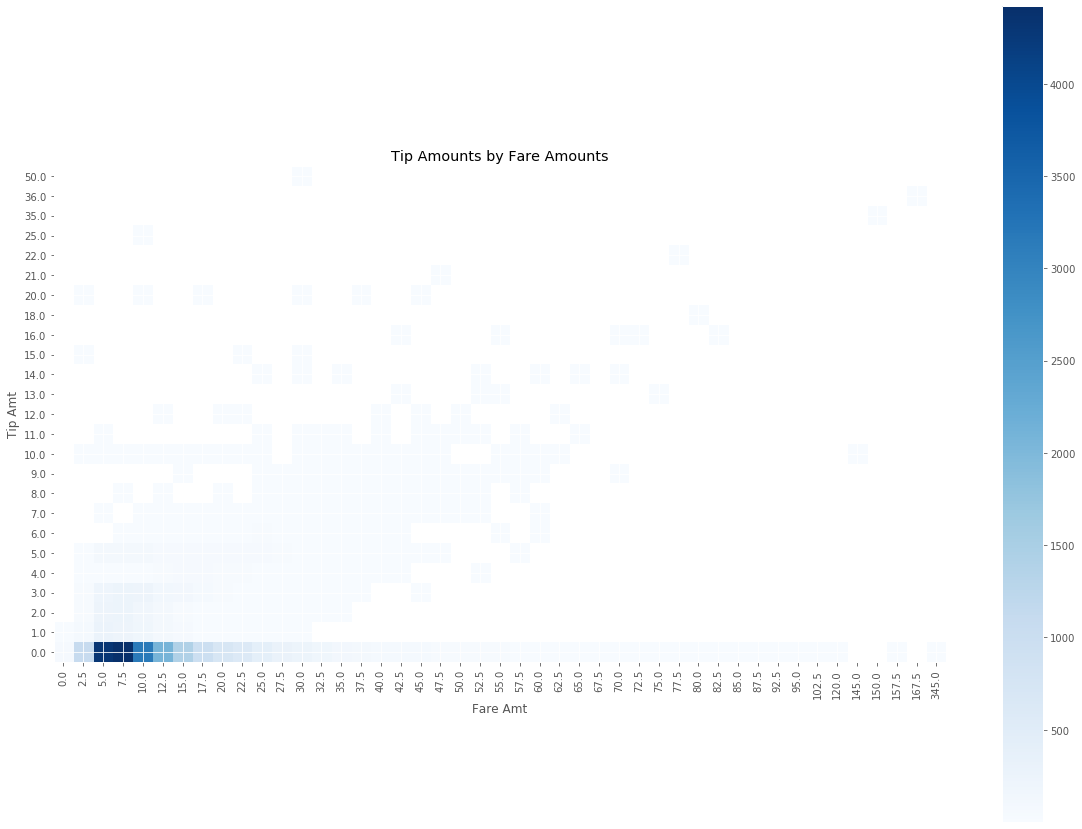

In [21]:
#https://www.pythonpool.com/matplotlib-figsize/
plt.figure(figsize=(20,15))
plt.axes().set_facecolor("#ffffff")
plt.axes().set_ylabel("Tip Amt")
plt.axes().set_xlabel("Fare Amt")
#https://www.pythonpool.com/matplotlib-heatmap/
plt.xticks(ticks=np.arange(len(fares)),labels=fares,rotation=90)
plt.yticks(ticks=np.arange(len(tips)),labels=tips)
hm = plt.imshow(hm_data,cmap='Blues',interpolation="none")
plt.colorbar(hm)
plt.title("Tip Amounts by Fare Amounts")

In [22]:
heatmap_data = df2.groupby('Pickup_Community_Area','Dropoff_Community_Area').count().\
                    sort('Pickup_Community_Area','Dropoff_Community_Area').groupby('Pickup_Community_Area').pivot('Dropoff_Community_Area').sum("count").sort('Pickup_Community_Area')
#heatmap_data = heatmap_data.groupby('Pickup_Community_Area').pivot('Dropoff_Community_Area').count()
heatmap_data.cache()

DataFrame[Pickup_Community_Area: double, null: bigint, 1.0: bigint, 2.0: bigint, 3.0: bigint, 4.0: bigint, 5.0: bigint, 6.0: bigint, 7.0: bigint, 8.0: bigint, 9.0: bigint, 10.0: bigint, 11.0: bigint, 12.0: bigint, 13.0: bigint, 14.0: bigint, 15.0: bigint, 16.0: bigint, 17.0: bigint, 18.0: bigint, 19.0: bigint, 20.0: bigint, 21.0: bigint, 22.0: bigint, 23.0: bigint, 24.0: bigint, 25.0: bigint, 26.0: bigint, 27.0: bigint, 28.0: bigint, 29.0: bigint, 30.0: bigint, 31.0: bigint, 32.0: bigint, 33.0: bigint, 34.0: bigint, 35.0: bigint, 36.0: bigint, 37.0: bigint, 38.0: bigint, 39.0: bigint, 40.0: bigint, 41.0: bigint, 42.0: bigint, 43.0: bigint, 44.0: bigint, 45.0: bigint, 46.0: bigint, 47.0: bigint, 48.0: bigint, 49.0: bigint, 50.0: bigint, 51.0: bigint, 52.0: bigint, 53.0: bigint, 54.0: bigint, 55.0: bigint, 56.0: bigint, 57.0: bigint, 58.0: bigint, 59.0: bigint, 60.0: bigint, 61.0: bigint, 62.0: bigint, 63.0: bigint, 64.0: bigint, 65.0: bigint, 66.0: bigint, 67.0: bigint, 68.0: bigint, 69

In [23]:
hm_data = np.array(heatmap_data.drop('Pickup_Community_Area').toPandas())

In [24]:
hm_data = np.flipud(hm_data.transpose())
#https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/
pickups = sorted(list(heatmap_data.select('Pickup_Community_Area').toPandas()['Pickup_Community_Area']))
dropoffs = sorted([float("nan") if x == "null" else float(x) for x in heatmap_data.columns if x != 'Pickup_Community_Area'], reverse=True)

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Tip Heatmap by Pickup and Dropoff Community Areas')

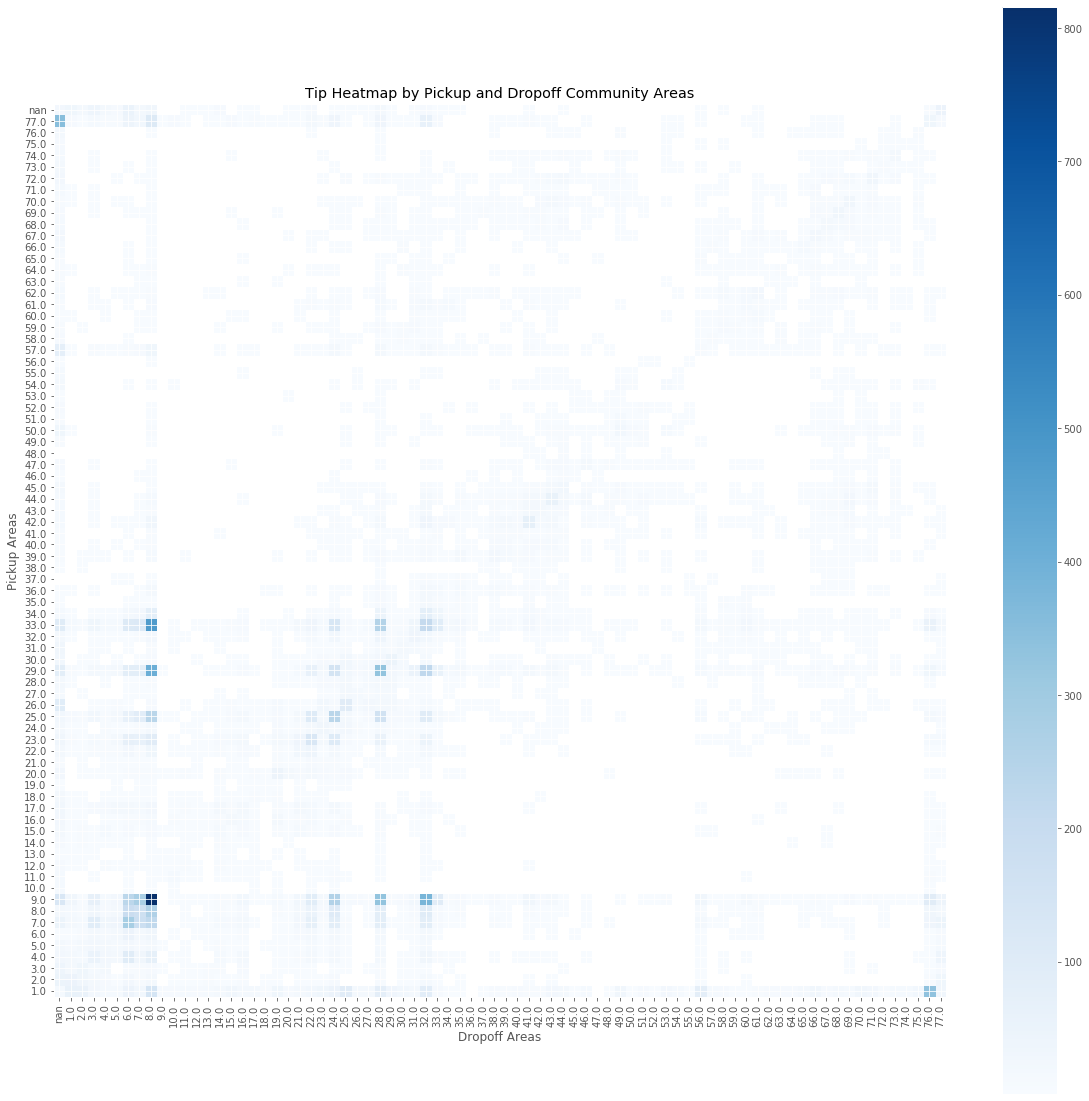

In [25]:
#https://www.pythonpool.com/matplotlib-figsize/
plt.figure(figsize=(20,20))
plt.axes().set_facecolor("#ffffff")
plt.axes().set_ylabel("Pickup Areas")
plt.axes().set_xlabel("Dropoff Areas")
#https://www.pythonpool.com/matplotlib-heatmap/
plt.xticks(ticks=np.arange(len(pickups)),labels=pickups,rotation=90)
plt.yticks(ticks=np.arange(len(dropoffs)),labels=dropoffs)
hm = plt.imshow(hm_data,cmap='Blues',interpolation="none")
plt.colorbar(hm)
plt.title("Tip Heatmap by Pickup and Dropoff Community Areas")

In [26]:
heatmap_data = df2.groupby('Pickup_Community_Area','Dropoff_Community_Area').count().\
                    sort('Pickup_Community_Area','Dropoff_Community_Area').groupby('Pickup_Community_Area').pivot('Dropoff_Community_Area').sum("count").sort('Pickup_Community_Area')
#heatmap_data = heatmap_data.groupby('Pickup_Community_Area').pivot('Dropoff_Community_Area').count()
heatmap_data.cache()

DataFrame[Pickup_Community_Area: double, null: bigint, 1.0: bigint, 2.0: bigint, 3.0: bigint, 4.0: bigint, 5.0: bigint, 6.0: bigint, 7.0: bigint, 8.0: bigint, 9.0: bigint, 10.0: bigint, 11.0: bigint, 12.0: bigint, 13.0: bigint, 14.0: bigint, 15.0: bigint, 16.0: bigint, 17.0: bigint, 18.0: bigint, 19.0: bigint, 20.0: bigint, 21.0: bigint, 22.0: bigint, 23.0: bigint, 24.0: bigint, 25.0: bigint, 26.0: bigint, 27.0: bigint, 28.0: bigint, 29.0: bigint, 30.0: bigint, 31.0: bigint, 32.0: bigint, 33.0: bigint, 34.0: bigint, 35.0: bigint, 36.0: bigint, 37.0: bigint, 38.0: bigint, 39.0: bigint, 40.0: bigint, 41.0: bigint, 42.0: bigint, 43.0: bigint, 44.0: bigint, 45.0: bigint, 46.0: bigint, 47.0: bigint, 48.0: bigint, 49.0: bigint, 50.0: bigint, 51.0: bigint, 52.0: bigint, 53.0: bigint, 54.0: bigint, 55.0: bigint, 56.0: bigint, 57.0: bigint, 58.0: bigint, 59.0: bigint, 60.0: bigint, 61.0: bigint, 62.0: bigint, 63.0: bigint, 64.0: bigint, 65.0: bigint, 66.0: bigint, 67.0: bigint, 68.0: bigint, 69

In [27]:
hm_data = np.array(heatmap_data.drop('Pickup_Community_Area').toPandas())

In [28]:
hm_data = np.flipud(hm_data.transpose())
#https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/
pickups = sorted(list(heatmap_data.select('Pickup_Community_Area').toPandas()['Pickup_Community_Area']))
dropoffs = sorted([float("nan") if x == "null" else float(x) for x in heatmap_data.columns if x != 'Pickup_Community_Area'], reverse=True)

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Tip Heatmap by Pickup and Dropoff Community Areas')

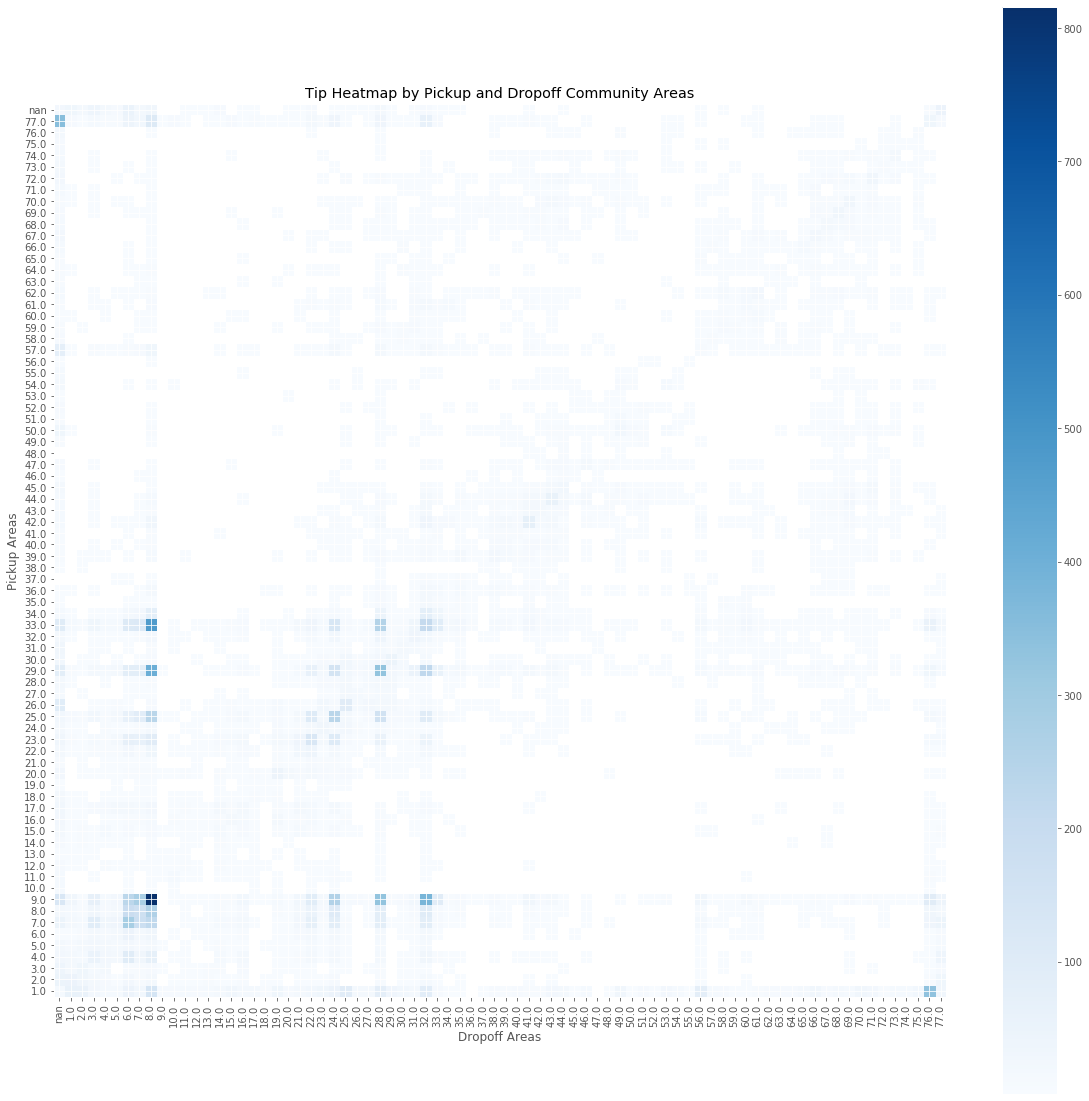

In [29]:
#https://www.pythonpool.com/matplotlib-figsize/
plt.figure(figsize=(20,20))
plt.axes().set_facecolor("#ffffff")
plt.axes().set_ylabel("Pickup Areas")
plt.axes().set_xlabel("Dropoff Areas")
#https://www.pythonpool.com/matplotlib-heatmap/
plt.xticks(ticks=np.arange(len(pickups)),labels=pickups,rotation=90)
plt.yticks(ticks=np.arange(len(dropoffs)),labels=dropoffs)
hm = plt.imshow(hm_data,cmap='Blues',interpolation="none")
plt.colorbar(hm)
plt.title("Tip Heatmap by Pickup and Dropoff Community Areas")

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


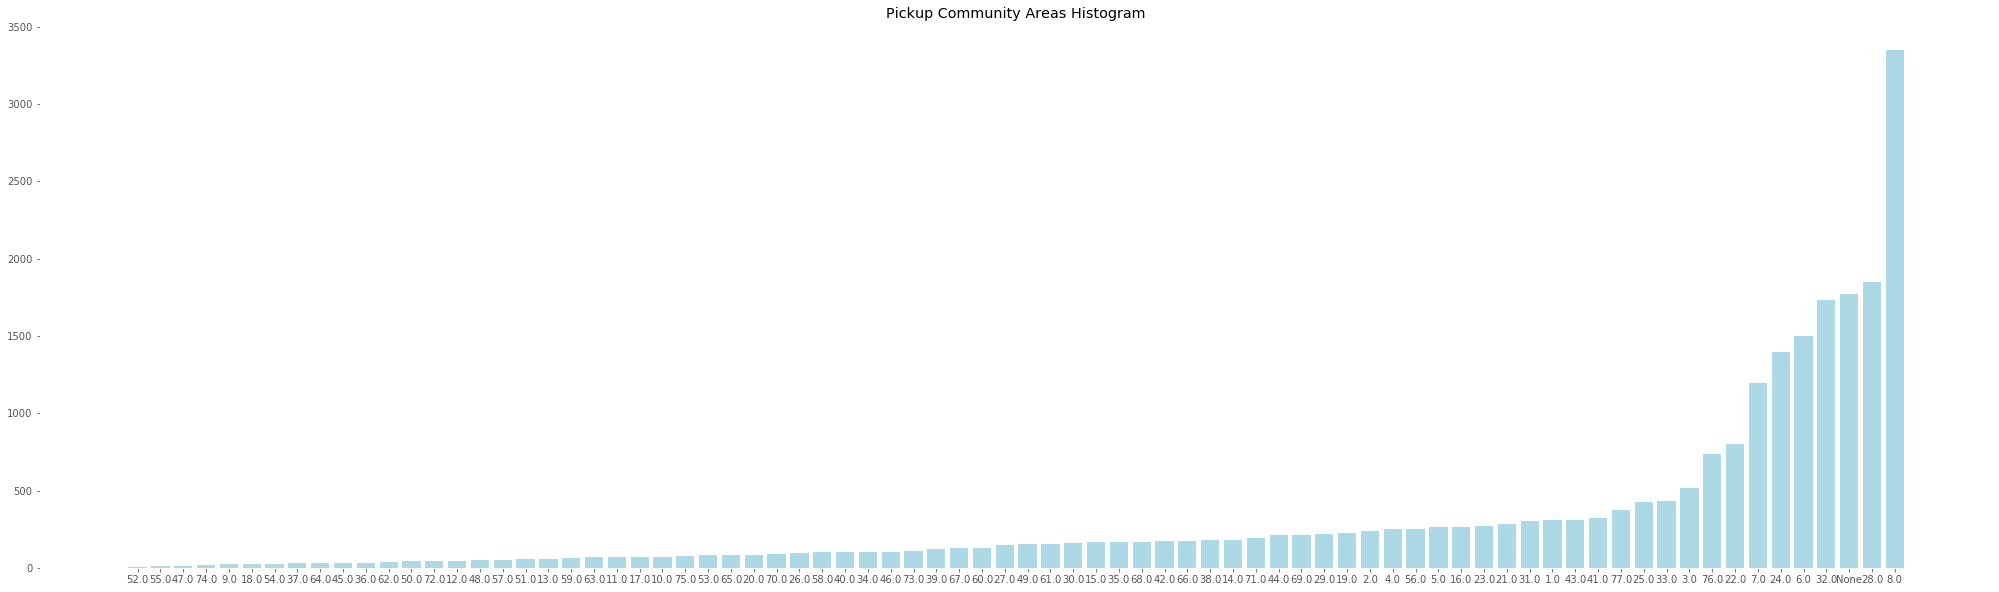

In [30]:
pickups_hist = df2.groupby('Pickup_Community_Area').count().withColumnRenamed("count","area_count").sort("area_count")
#https://stackoverflow.com/questions/38610559/convert-spark-dataframe-column-to-python-list
areas = [str(x.Pickup_Community_Area) for x in pickups_hist.collect()]
area_count = [x.area_count for x in pickups_hist.collect()]
plt.figure(figsize=(35,10))
plt.bar(areas,area_count, color='lightblue')
plt.title('Pickup Community Areas Histogram')
plt.axes().set_facecolor("#ffffff")

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


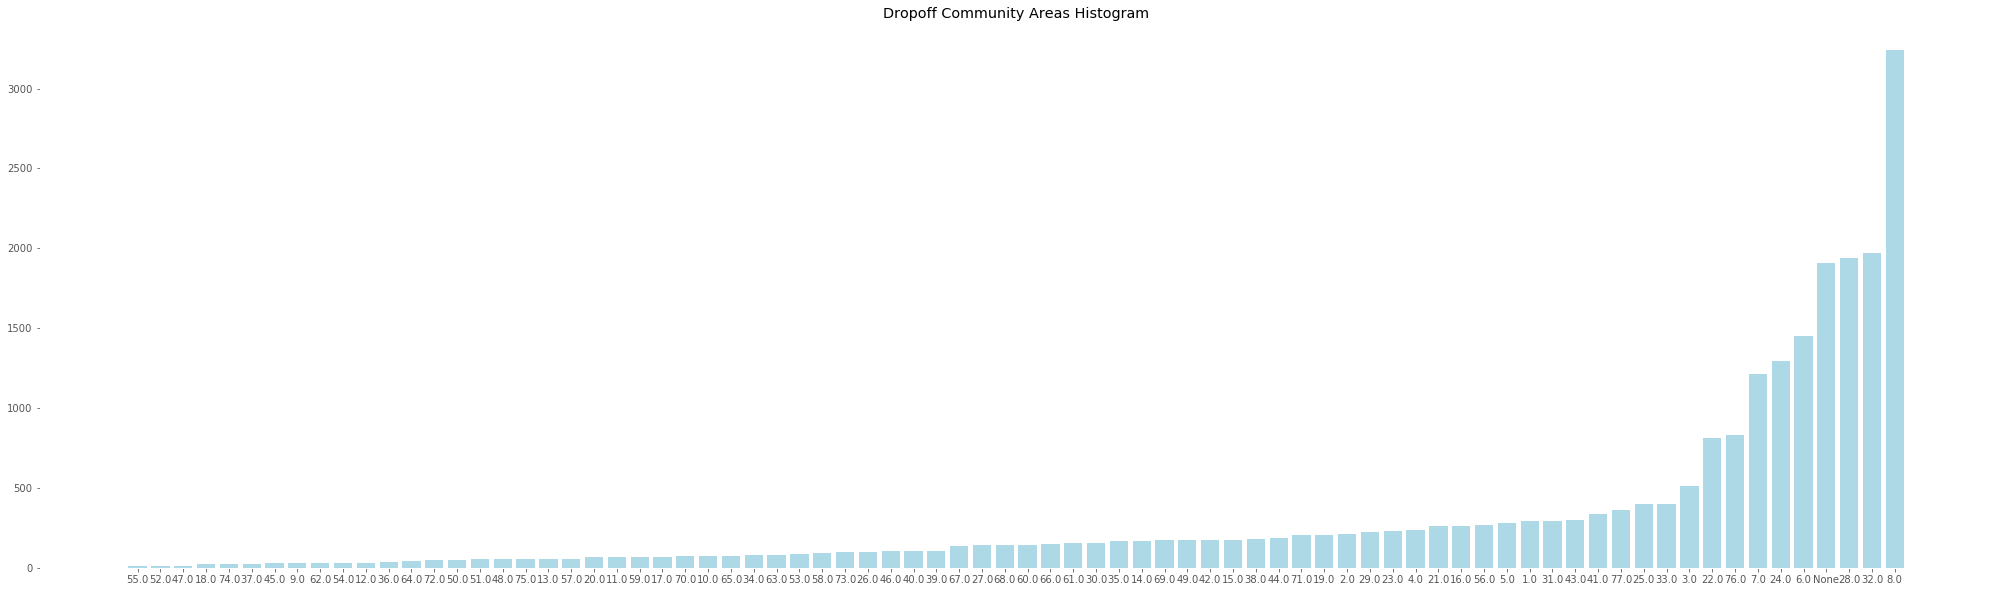

In [31]:
dropoffs_hist = df2.groupby('Dropoff_Community_Area').count().withColumnRenamed("count","area_count").sort("area_count")
areas = [str(x.Dropoff_Community_Area) for x in dropoffs_hist.collect()]
area_count = [x.area_count for x in dropoffs_hist.collect()]
plt.figure(figsize=(35,10))
plt.bar(areas,area_count, color='lightblue')
plt.title('Dropoff Community Areas Histogram')
plt.axes().set_facecolor("#ffffff")

Only showing top 10 as we have pretty large fall off.  Now to replace nulls with actual values.  Will use 99 for areas outside the city

In [32]:
#now lets sort the list, added desc to order the list from largest to smallest

df2.groupby('Pickup_Community_Area').count().orderBy('count', ascending=False).show(10)

+---------------------+-----+
|Pickup_Community_Area|count|
+---------------------+-----+
|                  8.0| 3350|
|                 28.0| 1852|
|                 null| 1773|
|                 32.0| 1732|
|                  6.0| 1498|
|                 24.0| 1397|
|                  7.0| 1199|
|                 22.0|  798|
|                 76.0|  735|
|                  3.0|  515|
+---------------------+-----+
only showing top 10 rows



Just for reference https://www.google.com/maps/d/u/0/viewer?ll=41.91066822076546%2C-87.63676464181398&spn=0.340714%2C0.699692&msa=0&mid=1O-3Uot4mSetKW-M_govahruUjDc&z=12

Top Pickup Areas

* 8 is the area of Magnificiant Mile (high end shopping), the riverwalk (tourism, boat tours), Gold Coast Neigherborhood (very high income neigherhood), and Navy Pier (tourist trap)
* 28 is the Near West Side neigherborhoods of West Loop, Greektown, and Fulton's Market.  Lots of new condos and resturants.  Also has University of Illinois Chicago, the Medical District (University and VA hospitals) and the United Center (home of the Bull and Blackhawks)
* null is outside the city
* 32 is "The Loop" downtown busisness district, train El hub
* 6 is Lakeview, Near north neigherbood perdominatly white and has the Chciago Cubs Stadium
* 24 West Town and has the neigherborhoods of Wicker Park, Ukranian Village, and River West.  These neigherbohoods have all been ungergroing gentrification.
* 7 Lincoln Park.  Like Lakeview but more expensive.  Was one of the first neigherborhoods in Chicago to gentrify.  
* 22 Logan Square.  Edge of transitioning neigherbood.  More afforable for new gentrifiying owners.
* 76 O'Hare Airport
* 3 Uptown, north of Lakeview, similar to Logan Square.

In [33]:
# do the same for the dropoffs
df2.groupby('Dropoff_Community_Area').count().orderBy('count', ascending=False).show(10)

+----------------------+-----+
|Dropoff_Community_Area|count|
+----------------------+-----+
|                   8.0| 3241|
|                  32.0| 1972|
|                  28.0| 1942|
|                  null| 1911|
|                   6.0| 1449|
|                  24.0| 1296|
|                   7.0| 1213|
|                  76.0|  829|
|                  22.0|  814|
|                   3.0|  514|
+----------------------+-----+
only showing top 10 rows



just for reference https://www.google.com/maps/d/u/0/viewer?ll=41.91066822076546%2C-87.63676464181398&spn=0.340714%2C0.699692&msa=0&mid=1O-3Uot4mSetKW-M_govahruUjDc&z=12

Dropoff Areas

* 8is the area of Magnificiant Mile (high end shopping), the riverwalk (tourism, boat tours), Gold Coast Neigherborhood (very high income neigherhood), and Navy Pier (tourist trap)
* 32 is "The Loop" downtown busisness district, train El hub
* 28 is the Near West Side neigherborhoods of West Loop, Greektown, and Fulton's Market.  Lots of new condos and resturants.  Also has University of Illinois Chicago, the Medical District (University and VA hospitals) and the United Center (home of the Bull and Blackhawks)
* null is outside the city
* 6 is Lakeview, Near north neigherbood perdominatly white and has the Chciago Cubs Stadium
* 24 West Town and has the neigherborhoods of Wicker Park, Ukranian Village, and River West.  These neigherbohoods have all been ungergroing gentrification.
* 7 Lincoln Park. Like Lakeview but more expensive.  Was one of the first neigherborhoods in Chicago to gentrify.  
* 76 O'Hare Airport
* 22 Logan Square.  Edge of transitioning neigherbood.  More afforable for new gentrifiying owners.
* 3 Uptown, north of Lakeview, similar to Logan Square.

The lists are almost identical, just a few order changes.

How much of the traffic comes from these heavy use neigherborhoods?  

In [ ]:
# replace our null values in the pickup and dropoff locations
# https://stackoverflow.com/questions/42312042/how-to-replace-all-null-values-of-a-dataframe-in-pyspark

In [82]:
df3 = df2.na.fill(value=99,subset=['Pickup_Community_Area', 'Dropoff_Community_Area'])

In [35]:
df3.groupby('Dropoff_Community_Area').count().orderBy('count', ascending=False).show(10)

+----------------------+-----+
|Dropoff_Community_Area|count|
+----------------------+-----+
|                   8.0| 3241|
|                  32.0| 1972|
|                  28.0| 1942|
|                  99.0| 1911|
|                   6.0| 1449|
|                  24.0| 1296|
|                   7.0| 1213|
|                  76.0|  829|
|                  22.0|  814|
|                   3.0|  514|
+----------------------+-----+
only showing top 10 rows



In [36]:
df3.groupby('Pickup_Community_Area').count().orderBy('count', ascending=False).show(10)

+---------------------+-----+
|Pickup_Community_Area|count|
+---------------------+-----+
|                  8.0| 3350|
|                 28.0| 1852|
|                 99.0| 1773|
|                 32.0| 1732|
|                  6.0| 1498|
|                 24.0| 1397|
|                  7.0| 1199|
|                 22.0|  798|
|                 76.0|  735|
|                  3.0|  515|
+---------------------+-----+
only showing top 10 rows



looks like it works to change the nulls to a 99 for the community area.

Next lets add a colum with the tip or no tip as a binary

In [83]:
df3.show(20)

+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+
|             Trip_ID|Trip_Start_Timestamp|Trip_Seconds|Trip_Miles|Pickup_Community_Area|Dropoff_Community_Area|Fare|Tip|Additional_Charges|Trip_Total|Shared_Trip_Authorized|Trips_Pooled|
+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+
|923e2cd22e434fe90...|12/01/2019 12:15:...|       966.0|       4.6|                 28.0|                   6.0|10.0|0.0|              2.55|     12.55|                 false|         1.0|
|54fb0ae8d3d76bc94...|12/01/2019 12:45:...|       825.0|       3.3|                  7.0|                   5.0|10.0|0.0|              2.55|     12.55|                 false|         1.0|
|fc02ddb50acc2353e...|12/01/2019 01:00:...|       310.0|    

In [ ]:
#old code, Michaels worked better.  This should be deleted later

#do we need this lit function?
#https://hackersandslackers.com/transforming-pyspark-dataframes/
#from pyspark.sql.functions import lit, when, col
#df4 = df3.withColumn('testColumn', F.lit('this is a test'))
# that worked
#df4 = df3.withColumn('Tip_Bool', when((col("tip") > 0), 1).otherwise(0))
# df = df.withColumn([COLUMN_NAME]. F.when([CONDITIONAL], [COLUMN_VALUE]).otherwsie([COLUMN_VALUE]))

In [84]:
# the biniazier that Michael found

# https://spark.apache.org/docs/2.2.0/ml-features.html#binarizer

from pyspark.ml.feature import Binarizer
#binarizer = Binarizer(threshold=0.5, inputCol="feature", outputCol="binarized_feature")
binarizer = Binarizer(threshold=0, inputCol="Tip", outputCol="binarized_tip")
binarizedTip = binarizer.transform(df3)
df4=binarizedTip

display(binarizedTip)

DataFrame[Trip_ID: string, Trip_Start_Timestamp: string, Trip_Seconds: double, Trip_Miles: double, Pickup_Community_Area: double, Dropoff_Community_Area: double, Fare: double, Tip: double, Additional_Charges: double, Trip_Total: string, Shared_Trip_Authorized: boolean, Trips_Pooled: double, binarized_tip: double]

In [85]:
df4.show(50)

+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+
|             Trip_ID|Trip_Start_Timestamp|Trip_Seconds|Trip_Miles|Pickup_Community_Area|Dropoff_Community_Area|Fare|Tip|Additional_Charges|Trip_Total|Shared_Trip_Authorized|Trips_Pooled|binarized_tip|
+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+
|923e2cd22e434fe90...|12/01/2019 12:15:...|       966.0|       4.6|                 28.0|                   6.0|10.0|0.0|              2.55|     12.55|                 false|         1.0|          0.0|
|54fb0ae8d3d76bc94...|12/01/2019 12:45:...|       825.0|       3.3|                  7.0|                   5.0|10.0|0.0|              2.55|     12.55|                 false|         1.0|     

In [41]:
df4.groupby('Dropoff_Community_Area', 'binarized_tip').count().orderBy('count', ascending=False).show(50)

+----------------------+-------------+-----+
|Dropoff_Community_Area|binarized_tip|count|
+----------------------+-------------+-----+
|                   8.0|          0.0| 2634|
|                  28.0|          0.0| 1615|
|                  99.0|          0.0| 1565|
|                  32.0|          0.0| 1560|
|                   6.0|          0.0| 1168|
|                  24.0|          0.0| 1077|
|                   7.0|          0.0| 1019|
|                  22.0|          0.0|  668|
|                   8.0|          1.0|  607|
|                  76.0|          0.0|  571|
|                   3.0|          0.0|  419|
|                  32.0|          1.0|  412|
|                  25.0|          0.0|  370|
|                  99.0|          1.0|  346|
|                  28.0|          1.0|  327|
|                  33.0|          0.0|  316|
|                  41.0|          0.0|  293|
|                  43.0|          0.0|  287|
|                   6.0|          1.0|  281|
|         

i guess now we should start doing more statistics?

In [86]:
df4.groupby("binarized_tip").count().show()

+-------------+-----+
|binarized_tip|count|
+-------------+-----+
|          0.0|20376|
|          1.0| 4038|
+-------------+-----+



can we do a logistic model with what we have now?

In [87]:
df4.printSchema()

root
 |-- Trip_ID: string (nullable = true)
 |-- Trip_Start_Timestamp: string (nullable = true)
 |-- Trip_Seconds: double (nullable = true)
 |-- Trip_Miles: double (nullable = true)
 |-- Pickup_Community_Area: double (nullable = false)
 |-- Dropoff_Community_Area: double (nullable = false)
 |-- Fare: double (nullable = true)
 |-- Tip: double (nullable = true)
 |-- Additional_Charges: double (nullable = true)
 |-- Trip_Total: string (nullable = true)
 |-- Shared_Trip_Authorized: boolean (nullable = true)
 |-- Trips_Pooled: double (nullable = true)
 |-- binarized_tip: double (nullable = true)



In [88]:
predictor_col_for_lr = ['Trip_Seconds',
                        'Trip_Miles',
                        'Pickup_Community_Area',
                        'Dropoff_Community_Area',
                        'Fare',
                        'Additional_Charges',
                        'Shared_Trip_Authorized',
                        'Trips_Pooled']

# leaving out Trip_start_Timestamp for now as I don't know know to use the string

In [89]:
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler 
from pyspark.mllib.linalg import Vectors

In [90]:
# from last weeks homework
# use all of the fields as features

assembler = VectorAssembler(inputCols=predictor_col_for_lr, outputCol="features") 
transformed = assembler.transform(df4)
df5 = transformed

df5.show(5)

+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+--------------------+
|             Trip_ID|Trip_Start_Timestamp|Trip_Seconds|Trip_Miles|Pickup_Community_Area|Dropoff_Community_Area|Fare|Tip|Additional_Charges|Trip_Total|Shared_Trip_Authorized|Trips_Pooled|binarized_tip|            features|
+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+--------------------+
|923e2cd22e434fe90...|12/01/2019 12:15:...|       966.0|       4.6|                 28.0|                   6.0|10.0|0.0|              2.55|     12.55|                 false|         1.0|          0.0|[966.0,4.6,28.0,6...|
|54fb0ae8d3d76bc94...|12/01/2019 12:45:...|       825.0|       3.3|                  7.0|                   

In [91]:
# Feature scaling from our homework

#from https://spark.apache.org/docs/latest/ml-features#standardscaler

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df5)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(df5)
scaledData.show()

df6 = scaledData


+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+--------------------+--------------------+
|             Trip_ID|Trip_Start_Timestamp|Trip_Seconds|Trip_Miles|Pickup_Community_Area|Dropoff_Community_Area|Fare|Tip|Additional_Charges|Trip_Total|Shared_Trip_Authorized|Trips_Pooled|binarized_tip|            features|      scaledFeatures|
+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+--------------------+--------------------+
|923e2cd22e434fe90...|12/01/2019 12:15:...|       966.0|       4.6|                 28.0|                   6.0|10.0|0.0|              2.55|     12.55|                 false|         1.0|          0.0|[966.0,4.6,28.0,6...|[1.40508628421897...|
|54fb0ae8d3d76bc94...|12

In [93]:

#from https://spark.apache.org/docs/2.1.0/ml-tuning.html#train-validation-split
train, test = df6.randomSplit([0.8, 0.2], seed=2021)

train.show(5)
test.show(5)

+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+--------------------+--------------------+
|             Trip_ID|Trip_Start_Timestamp|Trip_Seconds|Trip_Miles|Pickup_Community_Area|Dropoff_Community_Area|Fare|Tip|Additional_Charges|Trip_Total|Shared_Trip_Authorized|Trips_Pooled|binarized_tip|            features|      scaledFeatures|
+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+--------------------+--------------------+
|016f5c09cc942f33e...|12/01/2019 07:00:...|       753.0|       2.4|                  6.0|                   8.0| 7.5|0.0|              2.55|     10.05|                 false|         1.0|          0.0|[753.0,2.4,6.0,8....|[1.09526912217069...|
|025f587d152ca9181...|12

In [109]:
test.count()

4796

In [94]:
df6.columns

['Trip_ID',
 'Trip_Start_Timestamp',
 'Trip_Seconds',
 'Trip_Miles',
 'Pickup_Community_Area',
 'Dropoff_Community_Area',
 'Fare',
 'Tip',
 'Additional_Charges',
 'Trip_Total',
 'Shared_Trip_Authorized',
 'Trips_Pooled',
 'binarized_tip',
 'features',
 'scaledFeatures']

In [95]:
from pyspark.ml.classification import LogisticRegression

In [96]:
# from the docs https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression

# Load training data
# training = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

lr = LogisticRegression(maxIter=3,
                        regParam=0.3,
                        elasticNetParam=0.8,
                        featuresCol="features",
                        labelCol="binarized_tip")

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

# not doing multinominal... this was from the example
# We can also use the multinomial family for binary classification
# mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
# mlrModel = mlr.fit(train)

# Print the coefficients and intercepts for logistic regression with multinomial family
# print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
# print("Multinomial intercepts: " + str(mlrModel.interceptVector))

Coefficients: (8,[],[])
Intercept: -1.6385919752629563


Make Predictions

In [97]:
prediction = lrModel.transform(test)
prediction.show(5)

df7 = prediction

+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+
|             Trip_ID|Trip_Start_Timestamp|Trip_Seconds|Trip_Miles|Pickup_Community_Area|Dropoff_Community_Area|Fare|Tip|Additional_Charges|Trip_Total|Shared_Trip_Authorized|Trips_Pooled|binarized_tip|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+--------------------+--------------------+------------+----------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+
|032f5a1fb7abe78a9...|12/01/2019 04:15:...|       564.0|       1.4|                  8.0|                   8

In [108]:
df7.count()

4796

In [98]:
# I can't find how to do this in a Dataframe.  Rip to an RDD I guess.  This feels stupid.

pred_rdd= df7.select('prediction').rdd.flatMap(lambda x: x)
label_rdd = df7.select('binarized_tip').rdd.flatMap(lambda x: x)

In [99]:
pred_rdd.take(5)

[0.0, 0.0, 0.0, 0.0, 0.0]

In [100]:
label_rdd.take(5)

[0.0, 0.0, 0.0, 0.0, 0.0]

In [106]:
pred_rdd.count()

4796

In [107]:
label_rdd.count()

4796

In [101]:
#looks like we can zip them together

predictionAndLabels =  pred_rdd.zip(label_rdd)

In [102]:
predictionAndLabels.take(5)

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]

In [103]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [104]:
metrics2 = MulticlassMetrics(predictionAndLabels)

cm1 = metrics2.confusionMatrix().toArray()

In [105]:
cm1

array([[3949.,    0.],
       [ 847.,    0.]])

In [110]:
#well that doesn't look aweseome.  Looks like we are only predicting no tip.  Might have to do some weighting magic.  Despite confusing myself, the number of results are correct since only 20% was used for the test, and 80% used in the training

stuff coppied for other Tahsman Notebooks that might be useful.  Not developed yet.

In [ ]:
# for each field, compute missing percentage
# from preprcessing example notebook

df.agg(*[
    (1 - F.count(c) / F.count('*')).alias(c + '_miss')
    for c in df.columns
]).show()

In [ ]:
# we might need to use this.  From the logistic regression example code
# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(' ')]
    return LabeledPoint(values[0], values[1:])

In [ ]:


parsedData = data.map(parsePoint)

# Print a record to understand the data structure
print(parsedData.take(1))

In [ ]:
# Build the model
# one line model build.  We may need to do multiple types
model = LogisticRegressionWithSGD.train(parsedData)

In [ ]:
#this example code is backwards.  we'd likely need to use Predictions and Labels as in the documentation
# Evaluating the model on training data
labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
print(labelsAndPreds.take(3))

In [ ]:
#bayes example

In [ ]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils

# Load the data file. Note this data is in sparse format.
data = MLUtils.loadLibSVMFile(sc, 'sample_libsvm_data.txt')
data.take(2)

In [ ]:
# Split data approximately into training (60%) and test (40%)
training, test = data.randomSplit([0.6, 0.4])

In [ ]:
# Train a naive Bayes model.
model = NaiveBayes.train(training, 1.0)

In [ ]:
# Make prediction and test accuracy.
labelsAndPreds = test.map(lambda p: (p.label, model.predict(p.features)))
accuracy = 1.0 * labelsAndPreds.filter(lambda pl: pl[0] == pl[1]).count() / test.count()
print('model accuracy {}'.format(accuracy))

# Source: https://spark.apache.org/docs/latest/mllib-naive-bayes.html

In [ ]:
#decision tree examples

In [ ]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.util import MLUtils

# Load and parse the data file
data = MLUtils.loadLibSVMFile(sc, 'sample_libsvm_data.txt')
data.take(2)

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [ ]:
# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=5, maxBins=32)

In [ ]:
# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(
    lambda lp: lp[0] != lp[1]).count() / float(testData.count())
print('Test Error = ' + str(testErr))

In [52]:
# my personal favorite... trees

**Tree-Based Ensemble Methods**

*Ensembles* combine multiple models together to produce a new model.  
They may consist of models of the same type (e.g., all decision trees) or mixed type (e.g., decision tree + neural net + svm)  

One of the fundamental results in machine learning is that multiple weak classifiers can be combined to produce a strong classifier.  

Ensembles are useful in reducing overfitting, since predictions are based on several different trees  

The two most popular tree-based ensemble methods are *Random Forests* and *Boosted Trees* (e.g. *Gradient-Boosted Trees*)  

They are popular because they are often very competitive  

The nice properties of decision trees carry over to ensembles of trees  

This combining step can proceed using different methods, including:  

- voting (for classification)
- averaging (for regression) 
- running model predictions through another model (classification and regression)

There are downsides to ensembles:  

- Multiple models need to be trained, loaded, and maintained  
- Model explanation is harder: no p-values like regression, several trees are feeding overall decision.  
There are methods to provide feature importance information, such as partial dependence plots.

**Random Forest**  
Ensembles of decision trees  

RFs inject two sources of randomness into modeling:  

1. At each step, randomly select $p$ features out of $n$ total features for possible inclusion (random subspace method)
2. Sample the original training set with replacement, up to the size of the original training set (bootstrapping of the training set)

The number of features to randomly select $p$ is a parameter  
The number of bootstrapped trees to grow $N$ is a parameter  

Since the trees are grown independently, the training and prediction tasks are embarrassingly parallel and can be assigned to multiple workers.

Classification prediction done by majority vote across trees

**Random Forest Implementation**

`from pyspark.mllib.tree import RandomForest`  

Two most important parameters (which should be tuned using $k$-fold cross validation):  

- `numTrees`: Number of trees in forest
More trees will increase accuracy but also training time  

- `maxDepth`: Maximum depth of each tree in forest
Increasing depth can increase power of model, but will take longer to train and can overfit  

Other important parameters:

- `subsamplingRate`: fraction of size of original training set (default=1.0 recommended)

- `featureSubsetStrategy`: specified as fraction or function of total number of features

**Random Forest Example: load data/train model/predict**  
NOTE: Very similar to Decision Tree code above


In [ ]:
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.util import MLUtils

data = MLUtils.loadLibSVMFile(sc, 'sample_libsvm_data.txt')
data.take(2)

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [ ]:
# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=1000, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=5, maxBins=32)

In [ ]:
# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(
    lambda lp: lp[0] != lp[1]).count() / float(testData.count())
print('Test Error = ' + str(testErr))

**Gradient-Boosted Trees**  

GBTs work by building a sequence of trees and combining their predictions at each iteration.  The trees constructed are generally *stumps* which use a single decision split.  A stump is an example of a weak learner.

This is different from random forests, where each tree independently gives predictions on each training instance.



A loss is specified and an optimization problem is solved whereby the objective is to minimize the loss of the model by adding weak learners using a gradient-descent-like procedure.

The procedure follows a stage-wise additive model, meaning that one new weak learner is
added at a time and existing weak learners are left unchanged.
For the original work, see:

*Friedman, Jerome H. "Greedy function approximation: a gradient boosting machine." Annals of Statistics (2001): 1189–1232.*


**Gradient-Boosted Trees Implementation**  

Since the trees are built in a sequential fashion, the algorithm can not be run in parallel.  
However, shallow trees (e.g., stumps) can be used effectively; this saves time versus random forests, which use deeper trees.

The loss function in classification problems is the log loss, equal to twice the binomial negative log likelihood.

Important parameters:
- `numIterations`:  equal to the number of trees in the ensemble.  More trees means longer runtime but also better performance up to a point.
- `learningRate`:  how quickly the model adapts on each iteration. A smaller value may help the algo have better performance, but at the cost of additional runtime. The documentation recommends NOT tuning this param.

The method `runWithValidation` can help mitigate overfitting.  It takes a training RDD and a validation RDD.

The training is stopped when the improvement in the validation error is not more than a certain tolerance (supplied by the `validationTol` argument in `BoostingStrategy`).

**GBT Example: load data/train model/predict**

In [ ]:
from pyspark.mllib.tree import GradientBoostedTrees
from pyspark.mllib.util import MLUtils

data = MLUtils.loadLibSVMFile(sc, 'sample_libsvm_data.txt')
data.take(2)

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [ ]:
# Train a GradientBoostedTrees model.
model = GradientBoostedTrees.trainClassifier(trainingData, categoricalFeaturesInfo={}, numIterations=10)

In [ ]:
# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(
    lambda lp: lp[0] != lp[1]).count() / float(testData.count())
print('Test Error = ' + str(testErr))

In [ ]:

df = spark.read.json('https://data.cityofchicago.org/api/odata/v4/m6dm-c72p')

In [ ]:
from sodapy import Socrata

In [ ]:
def download_dataset(domain, dataset_id):
    # for this exercise, we're not using an app token,
    # but you *should* sign-up and register for an app_token if you want to use the Socrata API
    client = Socrata(domain, app_token=None)
    offset = None
    data = []
    batch_size = 1000

    while True:
        records = client.get(dataset_id, offset=offset, limit=batch_size)
        data.extend(records)
        if len(records) < batch_size:
            break
        offset = offset + batch_size if (offset) else batch_size

    return pd.DataFrame.from_dict(data)

def download_permits_dataset():
    return seattle_permits_df if "seattle_permits_df" in globals() else download_dataset("data.seattle.gov", "k44w-2dcq")

# load Seattle permits data
seattle_permits_df = download_permits_dataset()